In [1]:
import pycaret
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pycaret.classification import setup, compare_models
from pycaret.classification import tune_model
from pycaret.classification import *
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

from pycaret.classification import load_model

import pickle

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
import pickle

[typing.List[typing.Any], ~_T]
[<class 'str'>, typing.List[str]]
[<class 'str'>, ~_T]
[ForwardRef('Distribution'), <class 'NoneType'>]
[<class 'setuptools.extern.packaging._structures.InfinityType'>, <class 'setuptools.extern.packaging._structures.NegativeInfinityType'>]
[<class 'setuptools.extern.packaging._structures.InfinityType'>, <class 'setuptools.extern.packaging._structures.NegativeInfinityType'>, typing.Tuple[str, int]]
[<class 'setuptools.extern.packaging._structures.InfinityType'>, <class 'setuptools.extern.packaging._structures.NegativeInfinityType'>, <class 'int'>, <class 'str'>]
[<class 'setuptools.extern.packaging._structures.InfinityType'>, <class 'setuptools.extern.packaging._structures.NegativeInfinityType'>, <class 'int'>, <class 'str'>, typing.Tuple[typing.Union[setuptools.extern.packaging._structures.InfinityType, setuptools.extern.packaging._structures.NegativeInfinityType, int, str], str], typing.Tuple[setuptools.extern.packaging._structures.NegativeInfinityType,

In [2]:
#Define the top3 classifier that has prediction score - for all transport and feature combination

def define_models(t,feature):

    if feature == "submd":
        if t =="influx":
            models =  ['XGBClassifier','RandomForestClassifier','GradientBoostingClassifier']

        elif t =="efflux":
            models = ['LGBMClassifier','ExtraTreesClassifier','RandomForestClassifier']

        elif t =="pampa":
            models = ['RandomForestClassifier','ExtraTreesClassifier','GradientBoostingClassifier']

        elif t =="bbb":
            models = ["LGBMClassifier","XGBClassifier","ExtraTreesClassifier"]

    elif feature == "subfp":
        if t =="influx":
            models =  ['AdaBoostClassifier','LinearDiscriminantAnalysis','LGBMClassifier']

        elif t =="efflux":
            models = ['LGBMClassifier','XGBClassifier','ExtraTreesClassifier']

        elif t =="pampa":
            models = ['XGBClassifier','GradientBoostingClassifier','LogisticRegression']

        elif t =="bbb":
            models = ["LogisticRegression","ExtraTreesClassifier","KNeighborsClassifier"]

    return models

In [3]:
#Load the DrugBank and Kpuu dataset

def load_df(valset,feature):

    if valset == "cns":
            file_name = f'../CNS/2_feature_creation/cns_validation_{feature}.csv'

    elif valset == "kpuu":
          file_name = f'../Kpuu/2_feature_creation/kpuu_validation_{feature}.csv'

    df = pd.read_csv(file_name, index_col=0)

    return df


In [4]:
#Load the trained model

def load_the_model(t,f,model_name):
    model_file = f'../models/{f}/combined_{f}_{t}_{model_name}_session_16_{f}'
    model = load_model(model_file)

    return model

In [5]:
#Make prediction

def make_prediction(model,df):
    predictions = predict_model(model, data=df, raw_score=True)
    
    return predictions

In [6]:
#Create a dataset to keep only the prediction relevant information

def clean_df_for_info(df,valset):

    if valset =="kpuu":
        columns_to_keep = ['status_activity','species','papyrus_SMILES','inchi_connectivity']
    elif valset =="cns":
        columns_to_keep = ['status_cns','papyrus_SMILES','papyrus_inchi_key','inchi_connectivity']

    df = df[columns_to_keep]

    return df

In [7]:
#Calculate the average prediction score

def calculate_average(df):

    avg = df.iloc[:, [-6, -4, -2]].mean(axis=1)
    avg_values_list = avg.tolist()

    return avg_values_list


Run the functions

In [8]:
#Define the variables to iterate through

features = ['submd','subfp']
transports = ['influx','efflux','pampa','bbb']
valsets = ["kpuu",'cns']

In [9]:
#Here we perform prediction separately for each target label: influx, efflux, PAMPA, BBB
#We collect prediction score, predicted class for each model and calculate average pred score and 

for valset in valsets:
    for f in features:
        df_raw = load_df(valset,f)
        df_info = clean_df_for_info(df_raw,valset)

        for t in transports: 
            models = define_models(t,f)
            print(f'{f} - {t} -{valset}')

            #Iterate through the models and make predictions
            for m in models:
                classifier = load_the_model(t,f,m)

                predictions = make_prediction(classifier,df_raw)

                pred_classes = predictions['prediction_label'].values
                probability_score= predictions['prediction_score_1'].values

                column_mod_score=f'{m}_pred_score_{t}'
                df_info[column_mod_score] = probability_score

                column_mod_class = f'{m}_pred_class_{t}'
                df_info[column_mod_class] = pred_classes

            #Calculate average prediction scre
            pred_score_means = calculate_average(df_info)
            column_score_mean = f'{t}_pred_score_mean'
            df_info[column_score_mean] = pred_score_means

            #Get the majority vote for final label
            counts = df_info.iloc[:, [-6, -4, -2]].apply(lambda x: (x == 1).sum(), axis=1)
            column_maj_class =f'{t}_majority_class'
            df_info[column_maj_class] = counts.apply(lambda x: 1 if x > 1 else 0)

        #Save the predictions
        file_name = f'{valset}_{f}_pred_scores_class.csv'
        df_info.to_csv(file_name, index=True)
                



submd - influx -kpuu
[<class 'str'>, <class 'int'>]
[typing.List, typing.Dict[str, typing.Any]]
[<class 'str'>, typing.Type[numpy.number]]
[<class 'float'>, <class 'numpy.float32'>, <class 'numpy.float64'>]
[<class 'str'>, <class 'bytearray'>, <class 'os.PathLike'>]
[<class 'ctypes.c_float'>, <class 'ctypes.c_double'>, <class 'ctypes.c_ulong'>, <class 'ctypes.c_ulonglong'>, <class 'ctypes.c_long'>, <class 'ctypes.c_longlong'>]
[<class '_ctypes._Pointer'>, <class '_ctypes._Pointer'>, <class '_ctypes._Pointer'>, <class '_ctypes._Pointer'>, <class '_ctypes._Pointer'>, <class '_ctypes._Pointer'>]
[typing.List, <class 'NoneType'>]
[typing.Sequence[str], <class 'NoneType'>]
[<class 'str'>, typing.List[str]]
[<class 'bytes'>, <class '_ctypes.Array'>]
[typing.Tuple[int, int], <class 'NoneType'>]
[<class '_ctypes.Array'>, <class '_ctypes._Pointer'>]
[typing.List[int], <class 'numpy.ndarray'>]
[<class 'xgboost.core.DMatrix'>, <class 'NoneType'>]
[typing.List, typing.Dict[str, typing.Any], <class

In [10]:
#load the file with majority vote information

def load_maj_class_files(valset,feature):
    file_name = f'{valset}_{feature}_pred_scores_class.csv'
    df = pd.read_csv(file_name, index_col=0)

    return df

Make plots

In [119]:
valsets = ['cns']
transports =['influx','efflux','pampa','bbb']
features = ['submd', 'subfp']

In [120]:
#Create swarm plot to investigate pred.score
def make_plot(df, valset,t,f):

    plt.figure(figsize=(3, 3))  # Adjust figure size if needed


    if valset == "cns":

        y_name = f'{t}_score'
        
        sns.swarmplot(data=df, x="status_cns", y=y_name, color='blue', alpha=0.5)  # Swarm plot
        #sns.boxplot(data=df, x="status_cns", y="comp_score_1", color='red', width=0.3)
        plt.xlabel("Targeting")
        plt.ylabel("Prediction Score")
        valset_title = 'DrugBank'

    elif valset == "kpuu":
        
        y_name = f'{t}_score'
        sns.swarmplot(data=df, x="status_activity", y=y_name , color='blue', alpha=0.5)  # Swarm plot
        #sns.boxplot(data=df, x="status_activity", y="comp_score_1", color='red', width=0.3)
        plt.xlabel("Activity")
        plt.ylabel("Prediction Score")
        valset_title = "Kp,uu"

    if t == "influx":
        t_title ="Influx"
    elif t =="efflux":
        t_title ="Efflux"
    elif t=="pampa":
        t_title="PAMPA"
    elif t=="bbb":
        t_title="BBB"

    if f =="submd":
        f_title ="Molecular Descriptors"
    elif f =="subfp":
        f_title="Molecular Fingerprints"

    plt.title(f'{t_title} Prediction Score with \n{f_title} on {valset_title}', fontsize=11)


    plt.gcf().set_size_inches(3, 3)
    file_name_svg = f'../plots_for_report/{valset}_{t}_{f}.svg'
    plt.savefig(file_name_svg, bbox_inches='tight')

    
    plt.show()

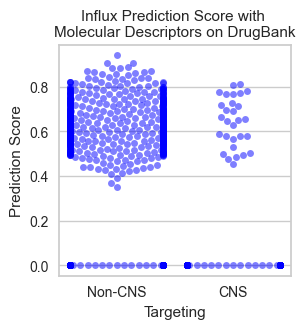

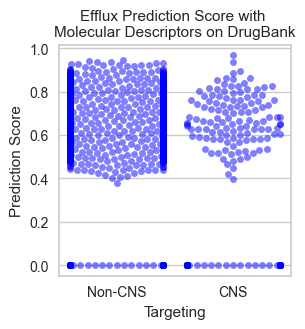

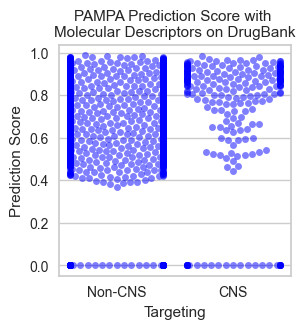

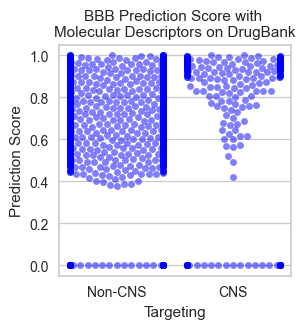

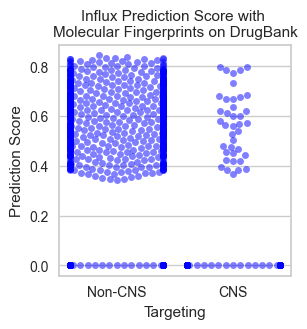

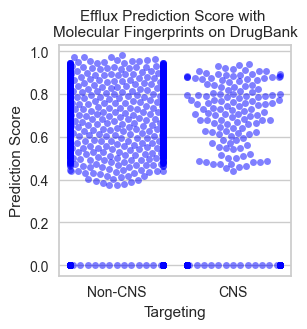

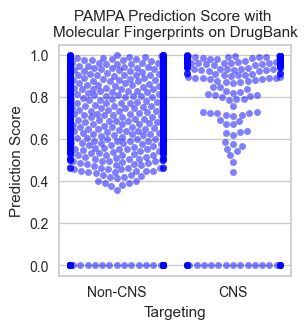

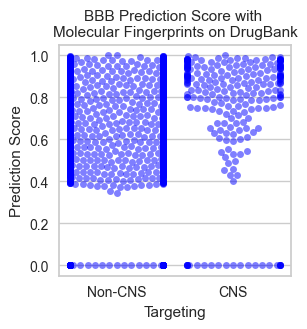

In [121]:
#Run the functions

for valset in valsets:
    for f in features:
        df = load_maj_class_files(valset,f)
        
        df['influx_score'] = df['influx_majority_class'] * df['influx_pred_score_mean']
        df['efflux_score'] = df['efflux_majority_class'] * df['efflux_pred_score_mean']
        df['pampa_score'] = df['pampa_majority_class'] * df['pampa_pred_score_mean']
        df['bbb_score'] = df['bbb_majority_class'] * df['bbb_pred_score_mean']
    
        for t in transports:
            make_plot(df, valset,t,f)